Early stopping at epoch 11


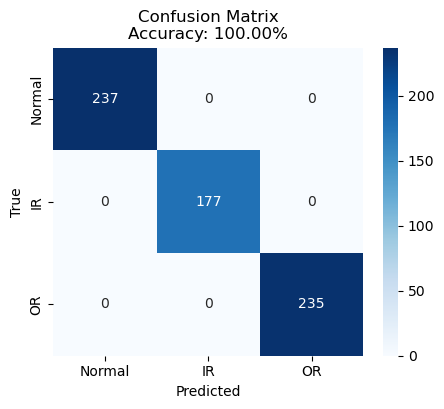

 - Model accuracy: 100.00%


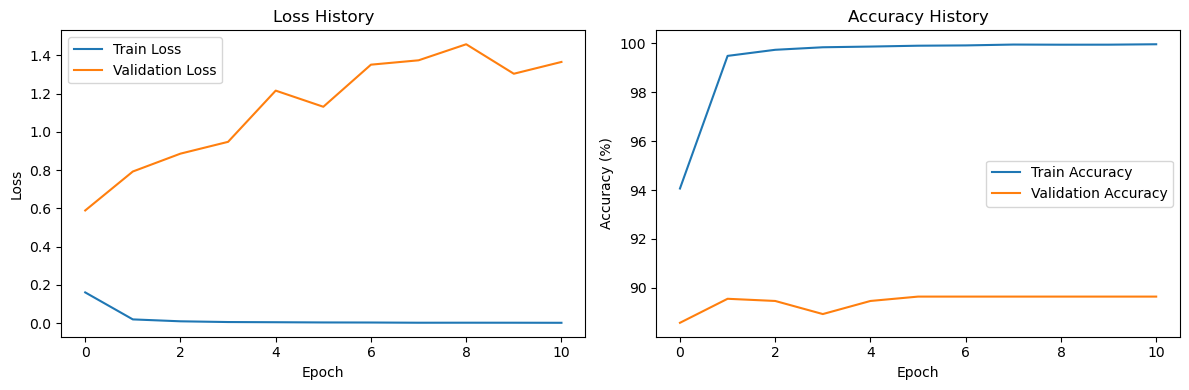

Early stopping at epoch 7


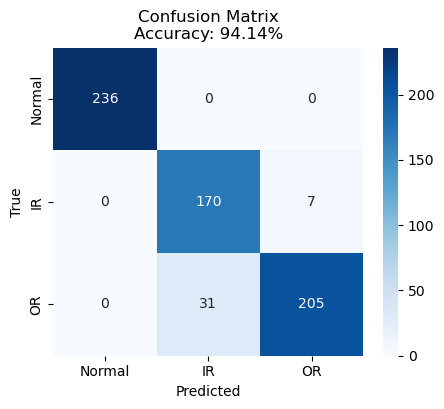

 - Model accuracy: 94.14%


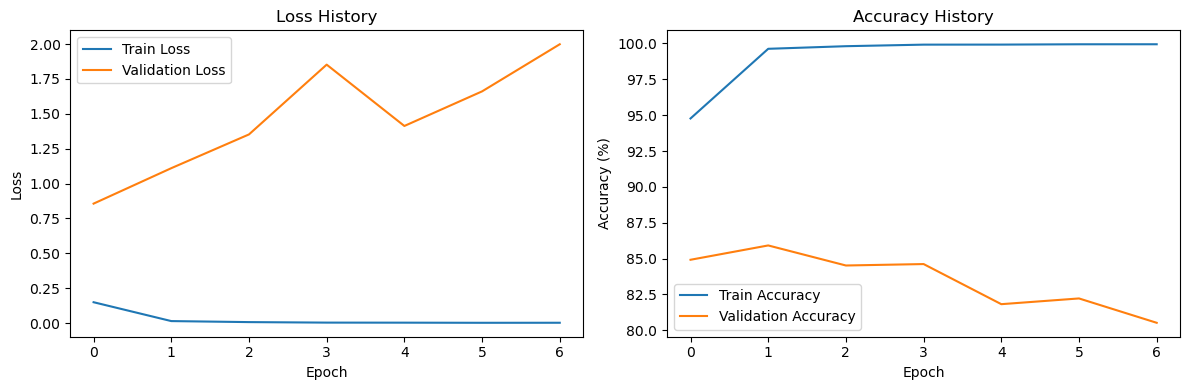

Early stopping at epoch 17


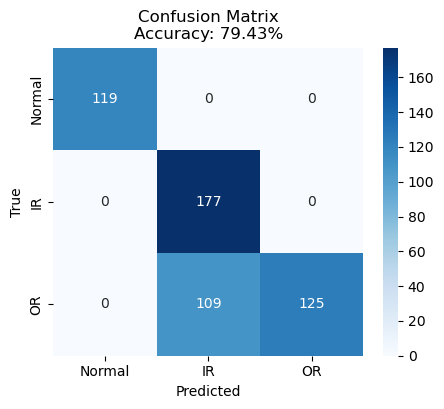

 - Model accuracy: 79.43%


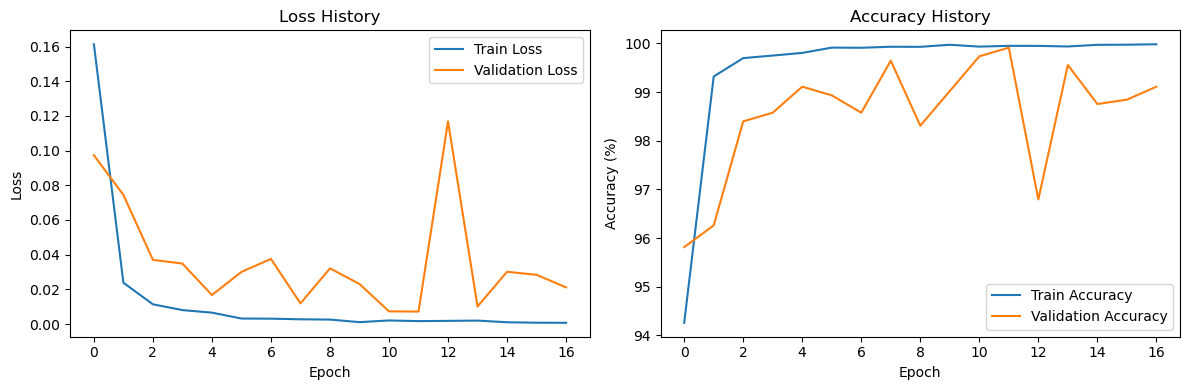

Early stopping at epoch 14


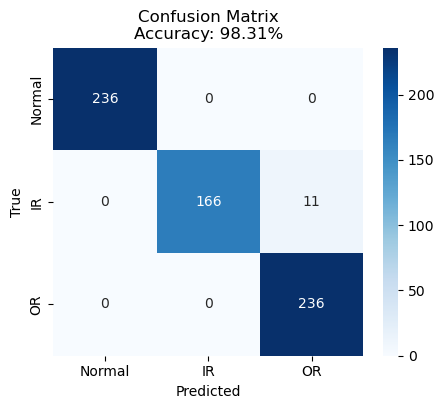

 - Model accuracy: 98.31%


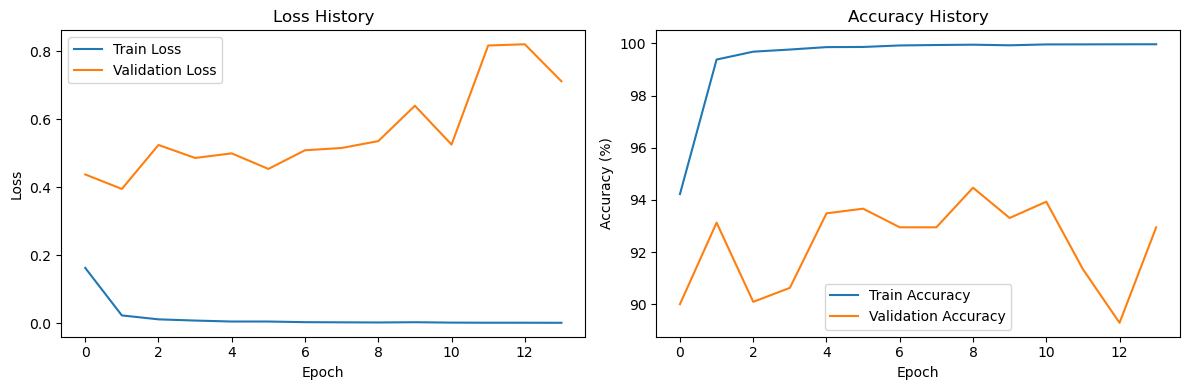

Early stopping at epoch 7


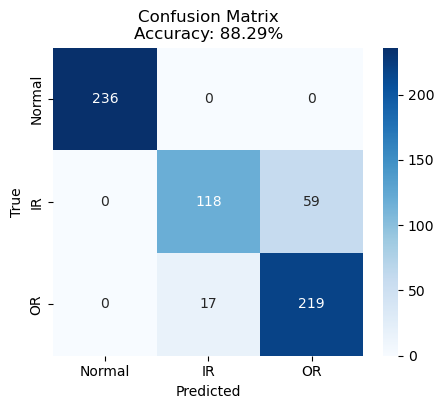

 - Model accuracy: 88.29%


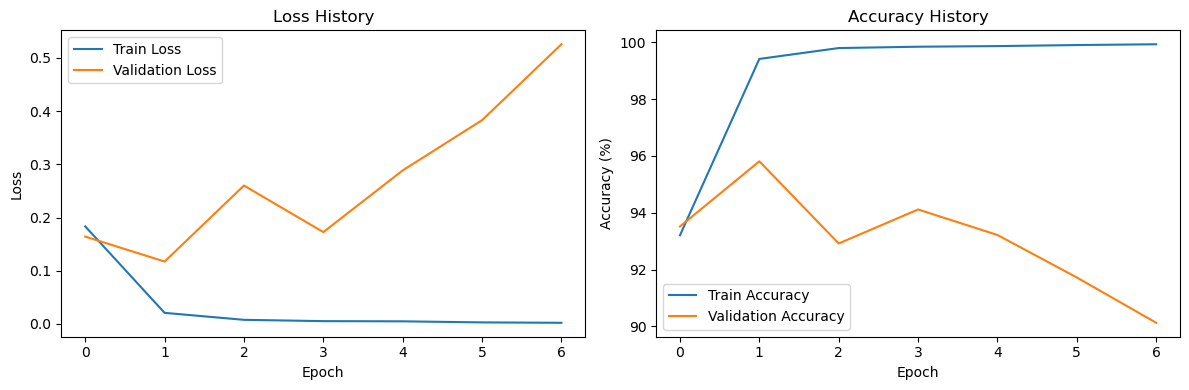

Early stopping at epoch 14


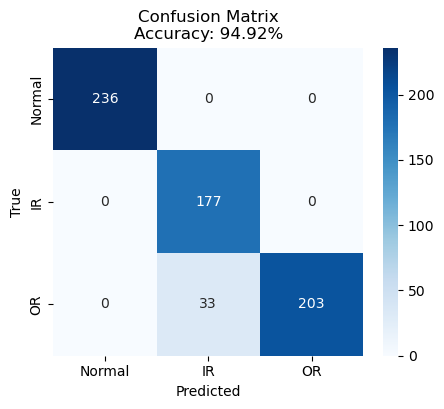

 - Model accuracy: 94.92%


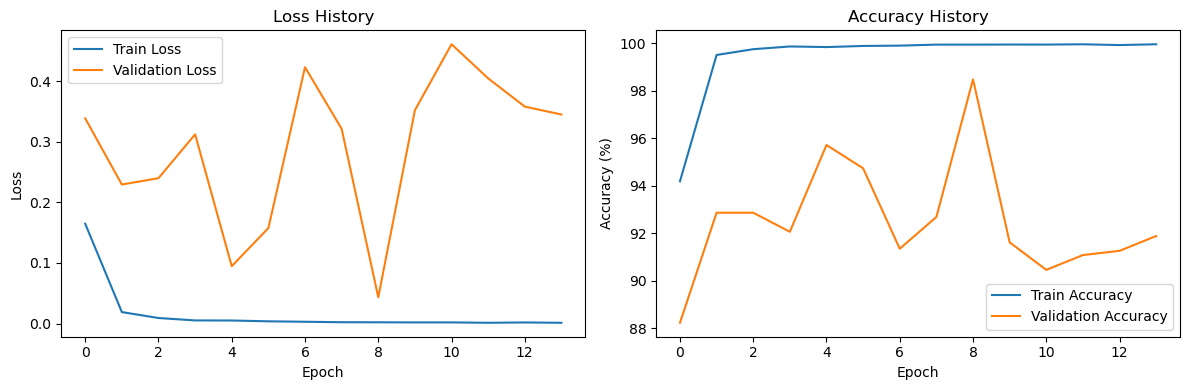

Early stopping at epoch 6


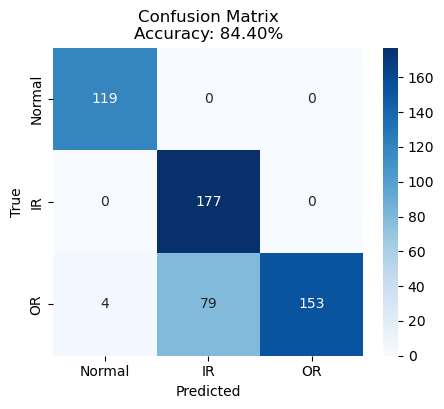

 - Model accuracy: 84.40%


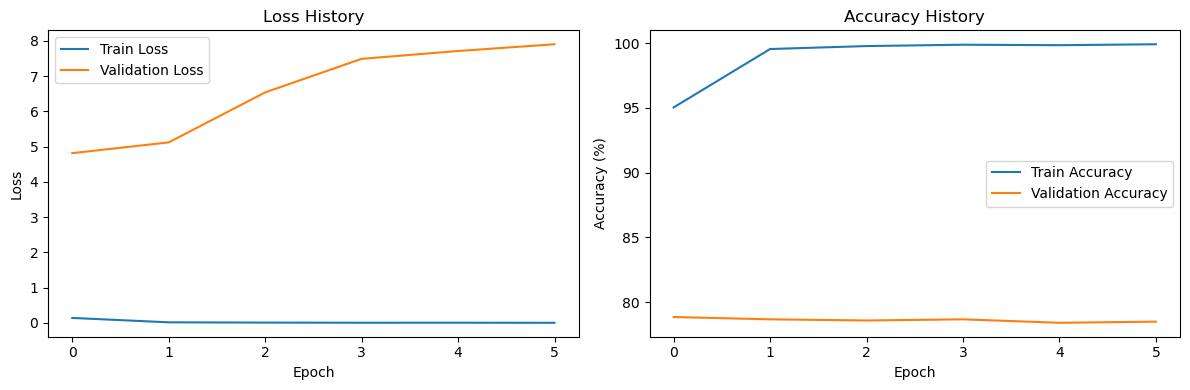

Early stopping at epoch 9


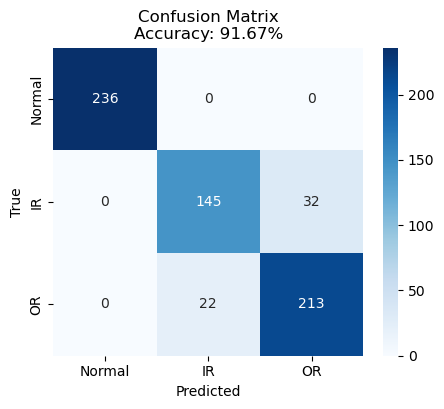

 - Model accuracy: 91.67%


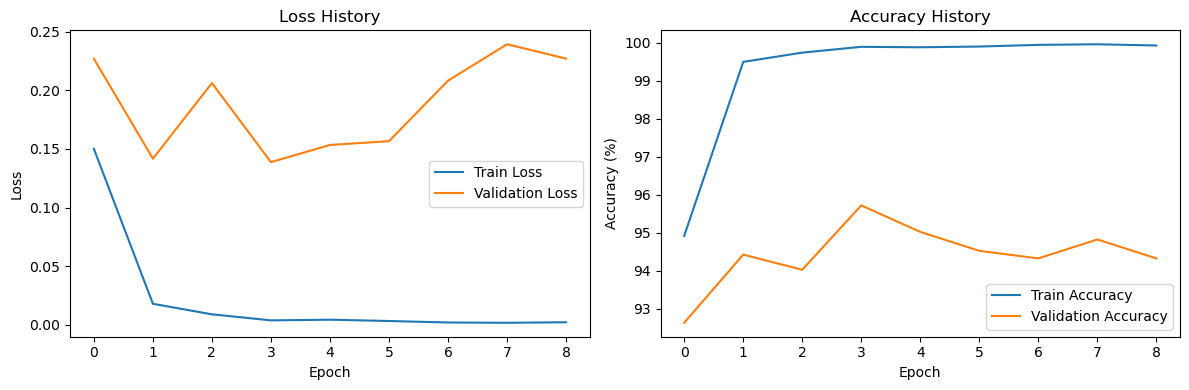

Early stopping at epoch 15


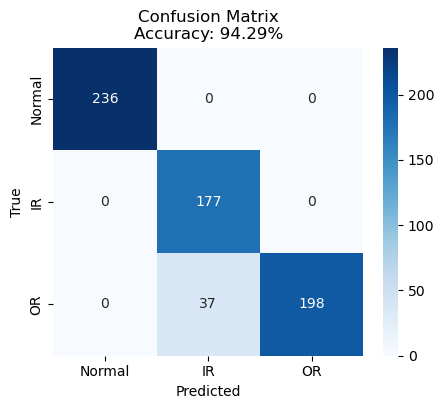

 - Model accuracy: 94.29%


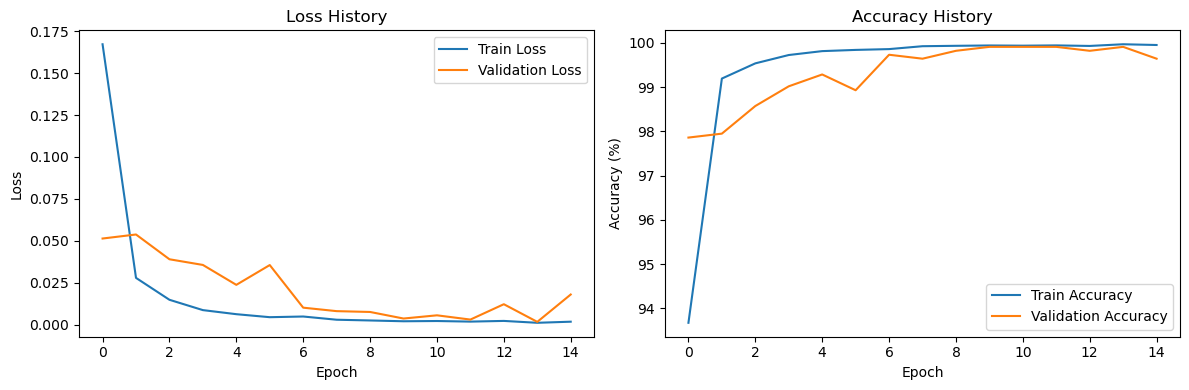

Early stopping at epoch 13


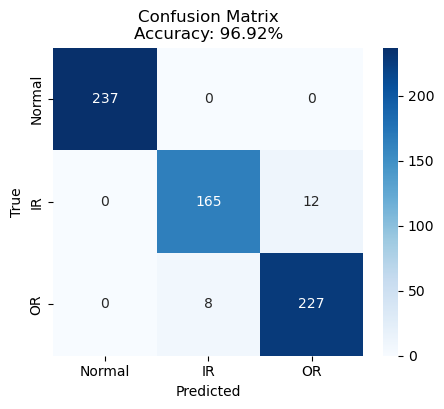

 - Model accuracy: 96.92%


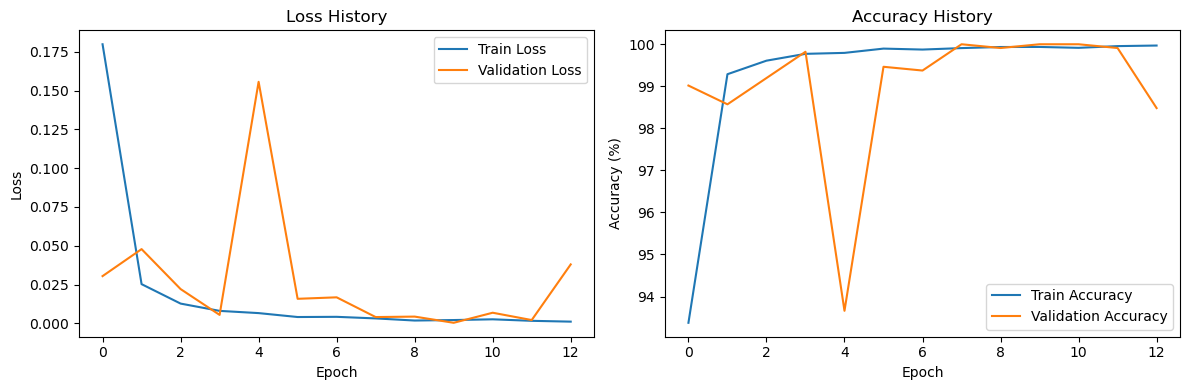

Early stopping at epoch 6


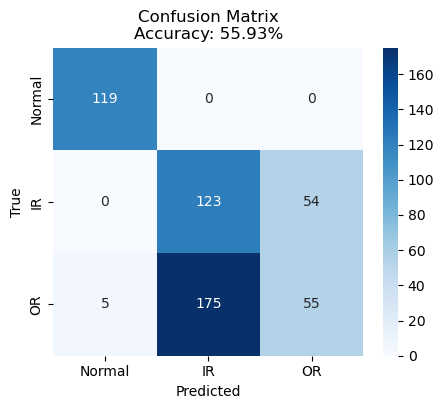

 - Model accuracy: 55.93%


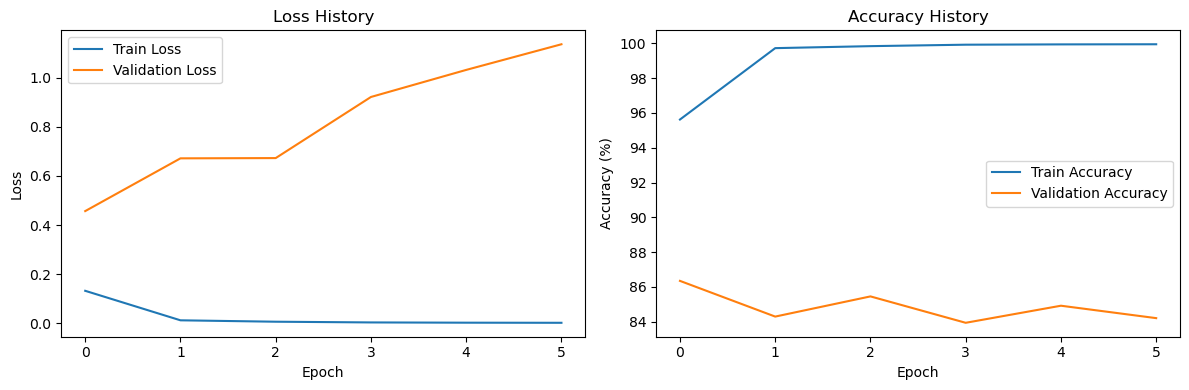

Early stopping at epoch 7


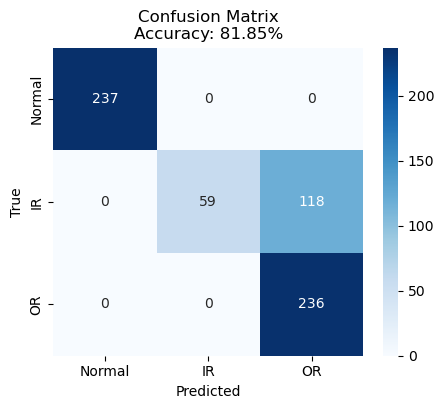

 - Model accuracy: 81.85%


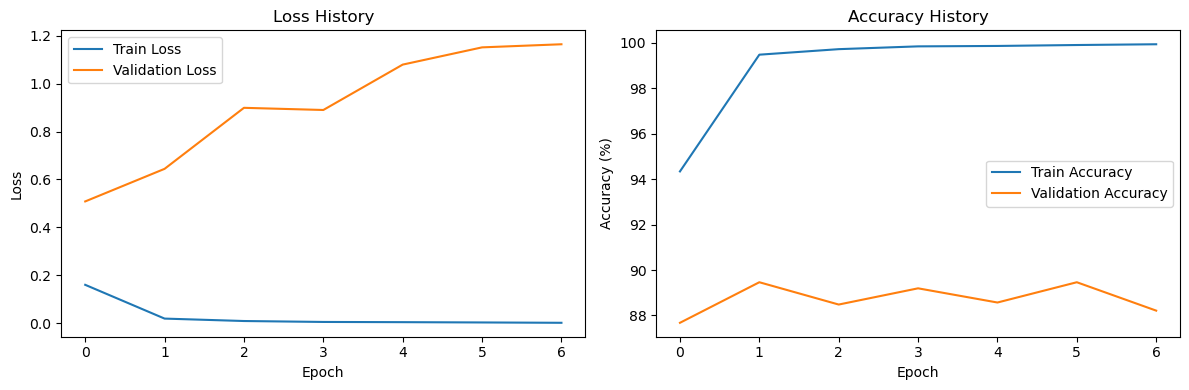

Early stopping at epoch 11


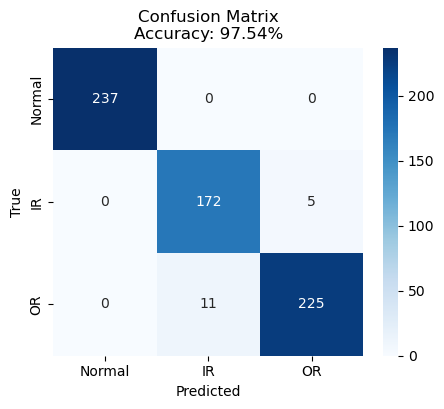

 - Model accuracy: 97.54%


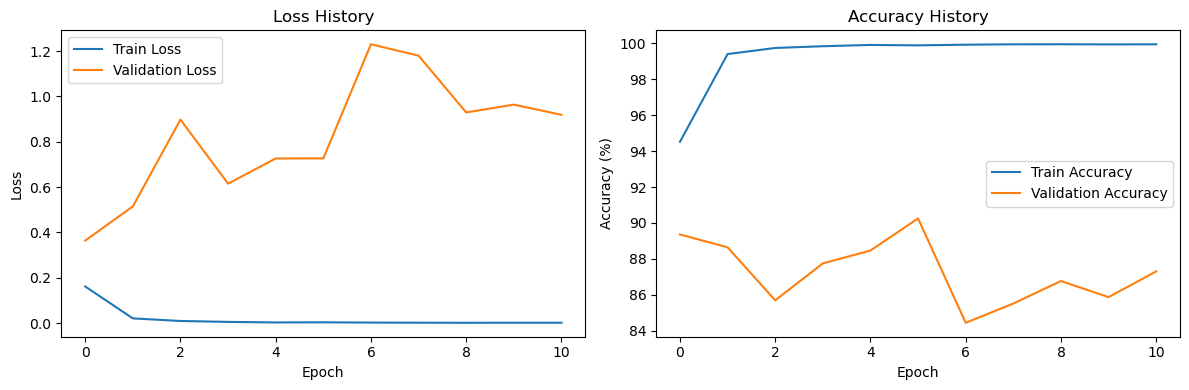

Early stopping at epoch 12


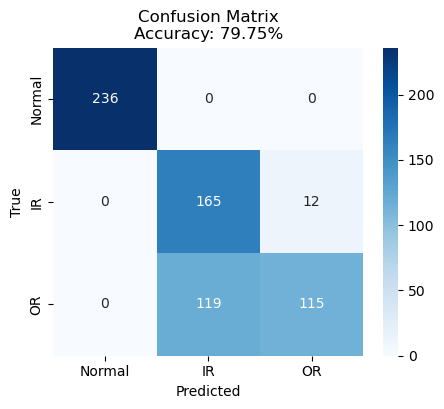

 - Model accuracy: 79.75%


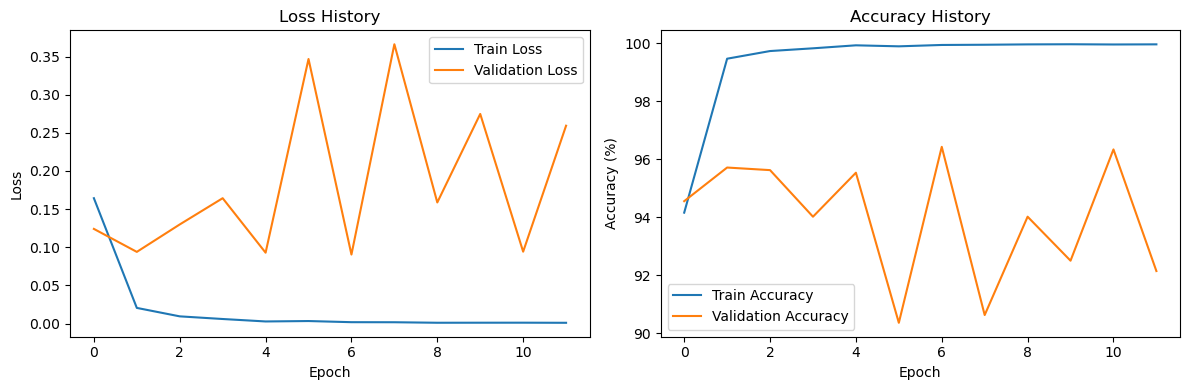

Early stopping at epoch 11


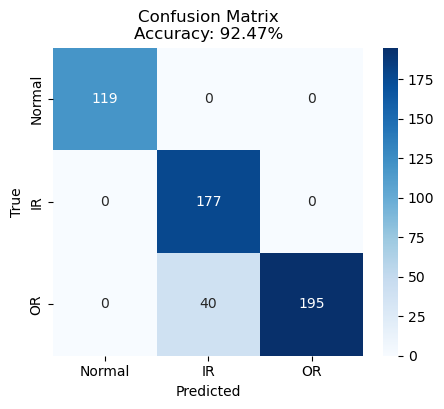

 - Model accuracy: 92.47%


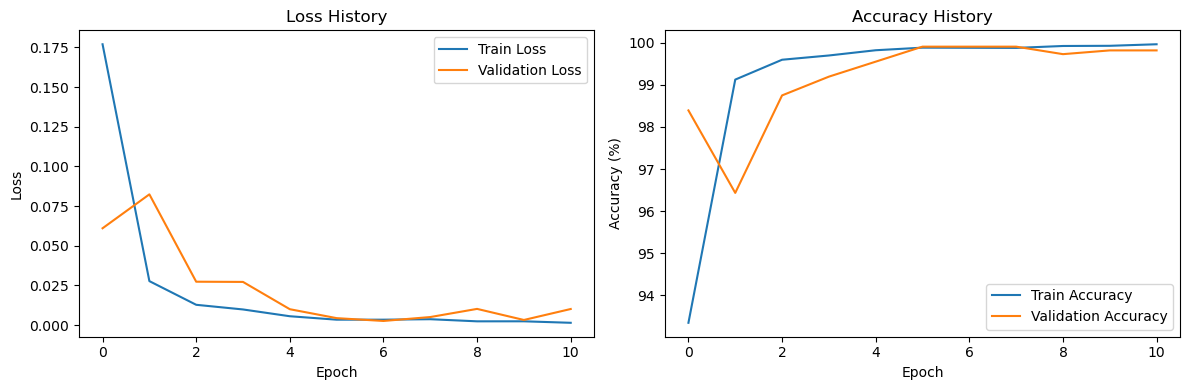

Early stopping at epoch 6


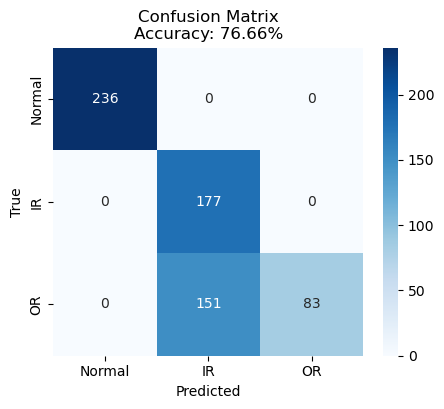

 - Model accuracy: 76.66%


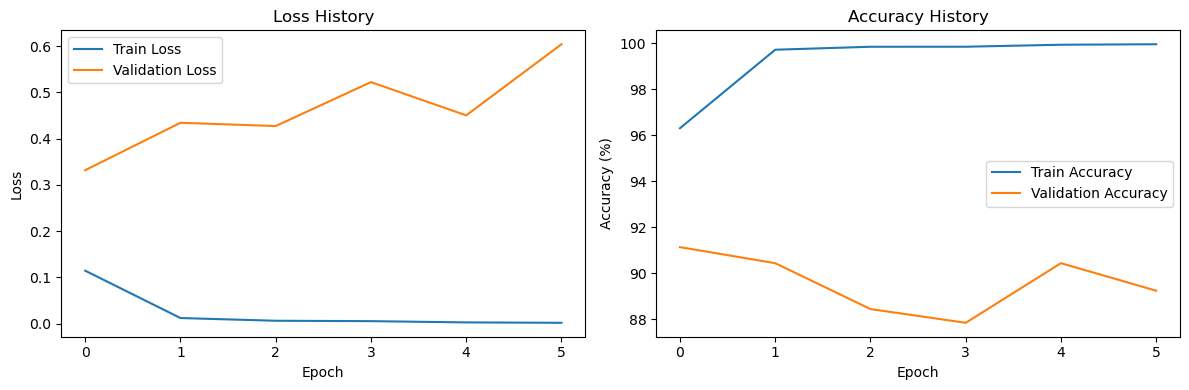

Early stopping at epoch 7


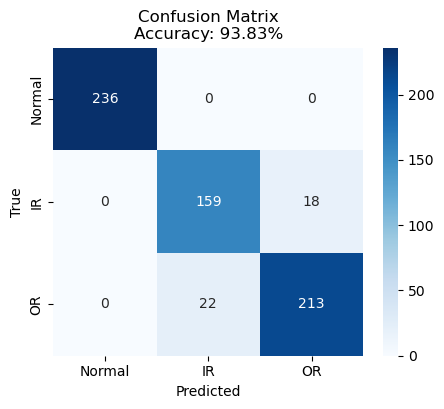

 - Model accuracy: 93.83%


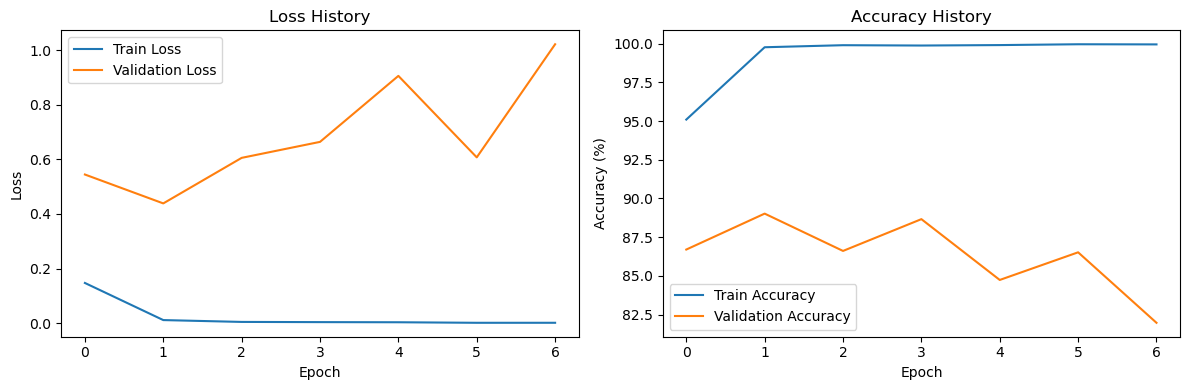

Early stopping at epoch 16


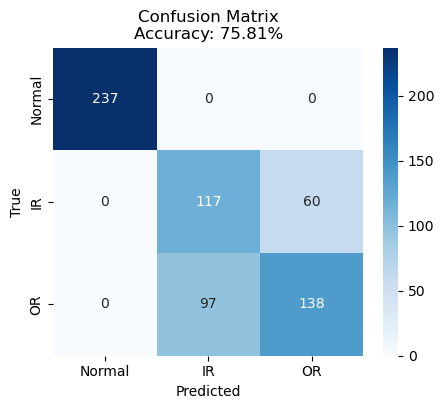

 - Model accuracy: 75.81%


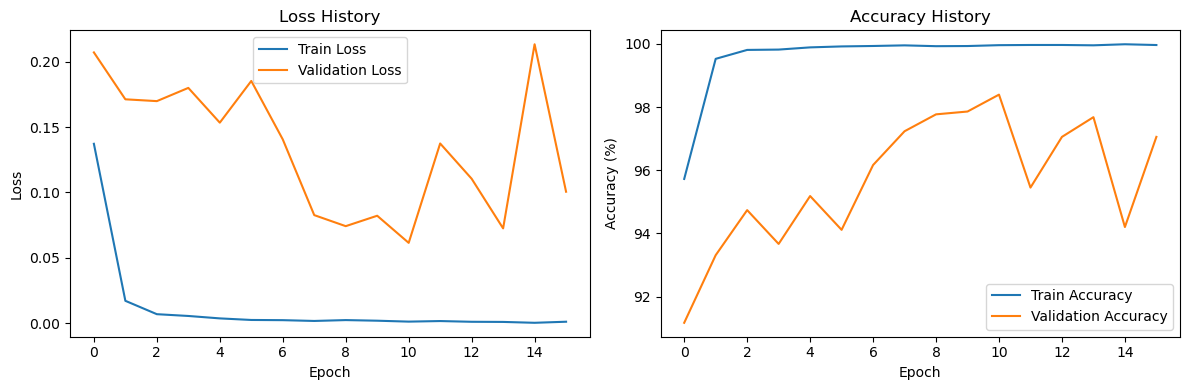

Early stopping at epoch 12


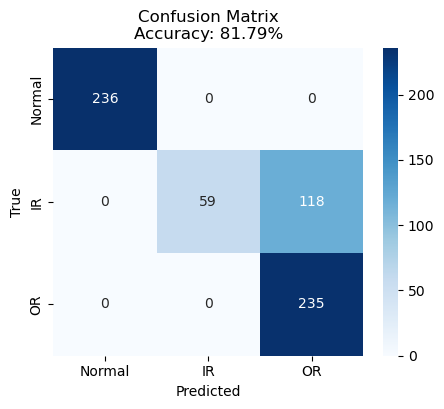

 - Model accuracy: 81.79%


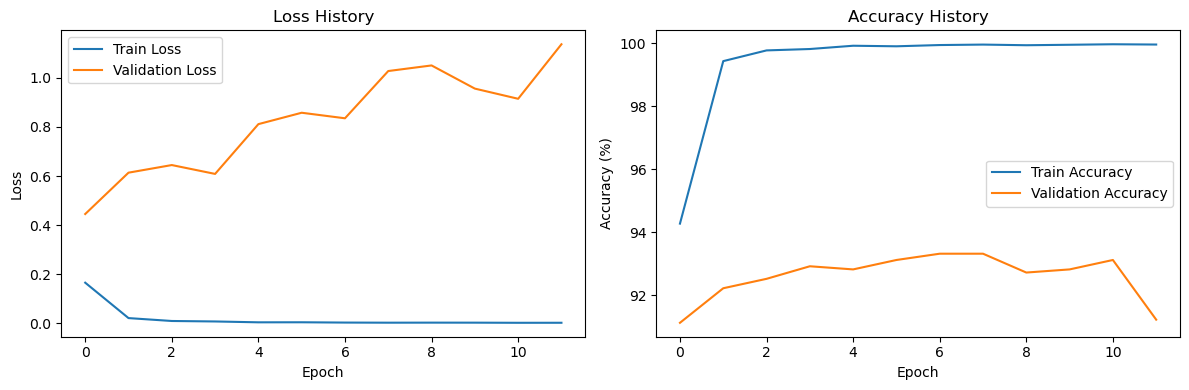

Early stopping at epoch 8


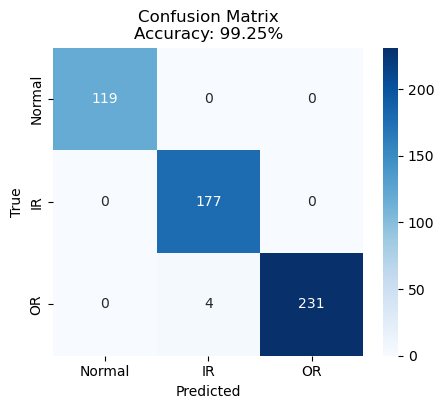

 - Model accuracy: 99.25%


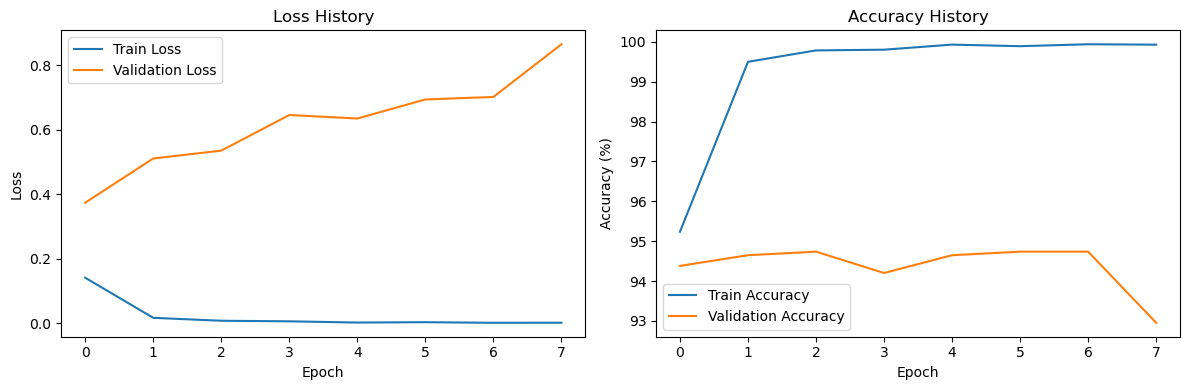

Early stopping at epoch 11


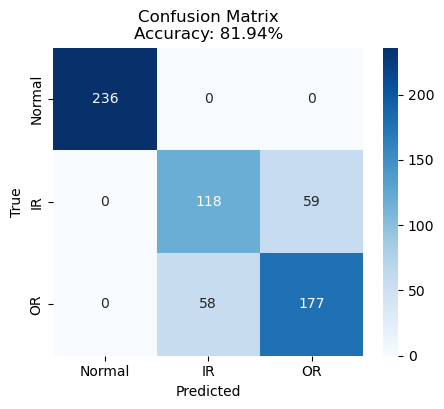

 - Model accuracy: 81.94%


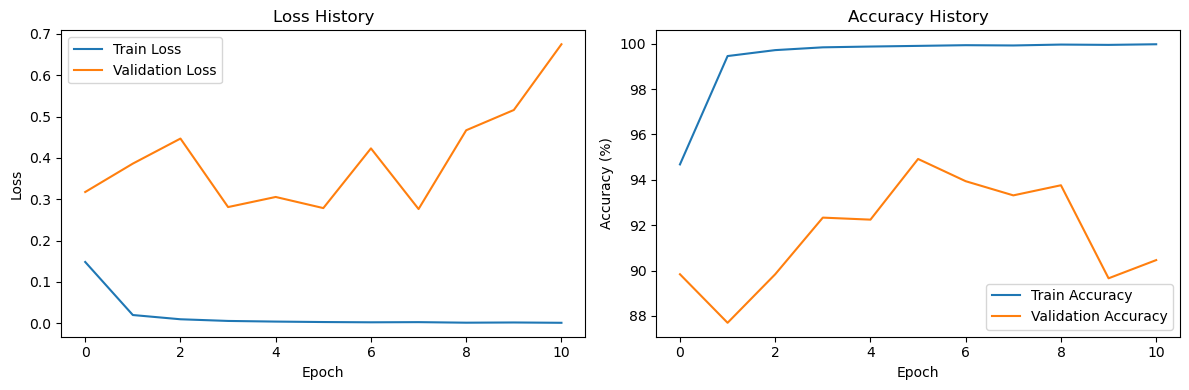

Early stopping at epoch 7


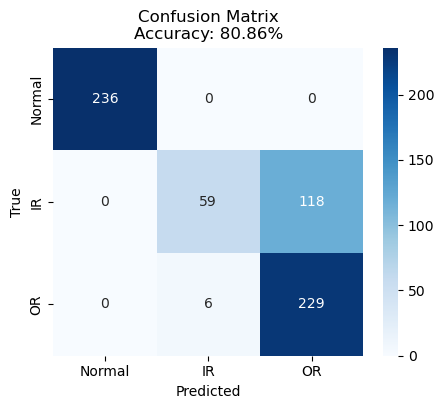

 - Model accuracy: 80.86%


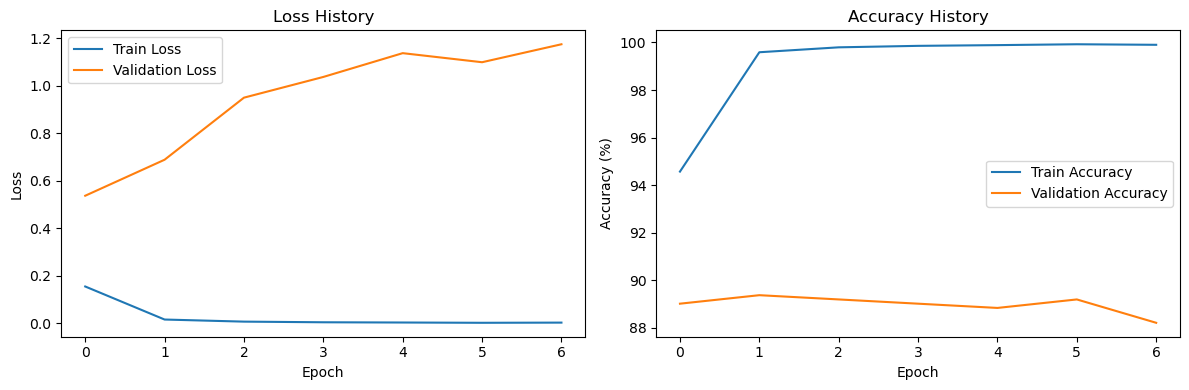

Early stopping at epoch 20


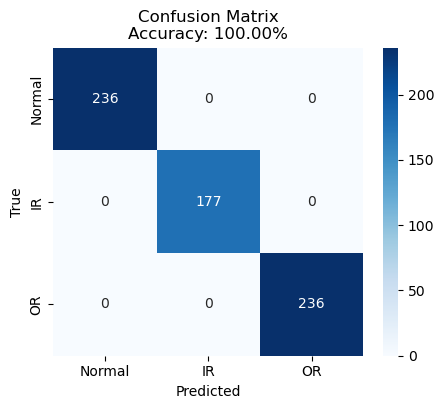

 - Model accuracy: 100.00%


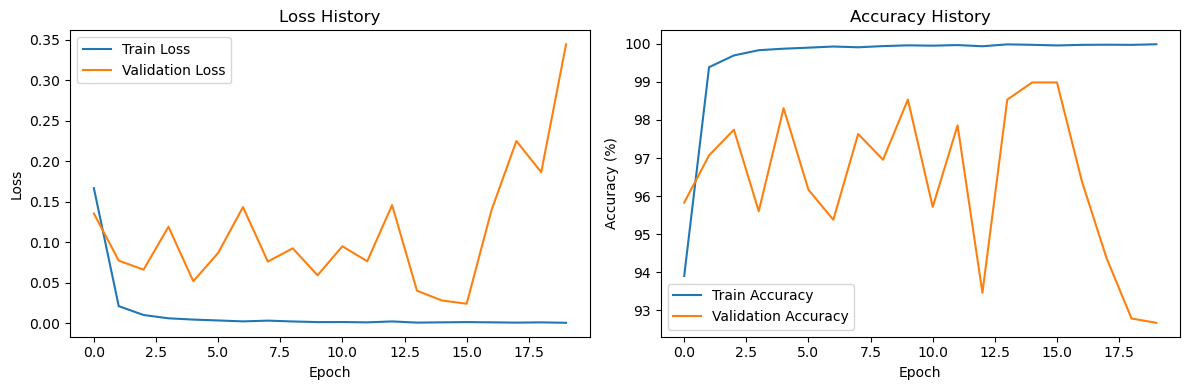

Early stopping at epoch 8


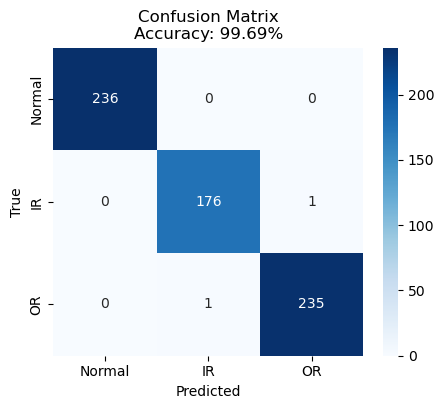

 - Model accuracy: 99.69%


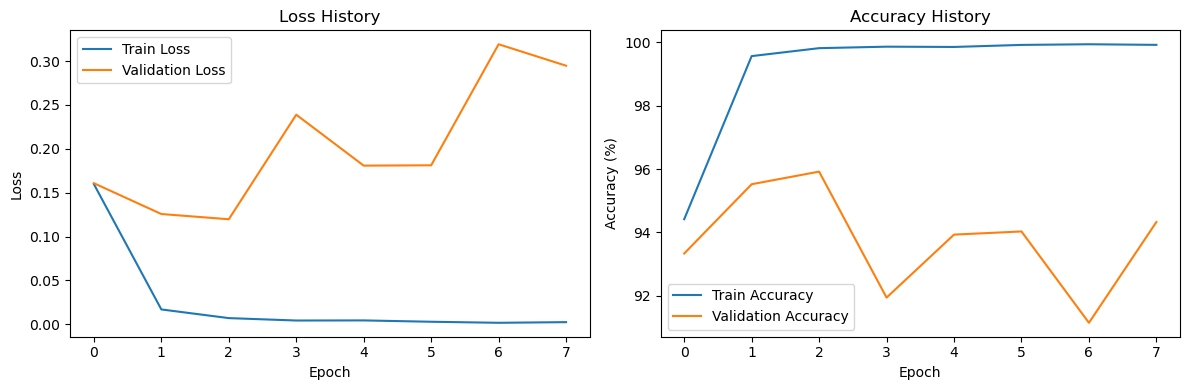

Early stopping at epoch 7


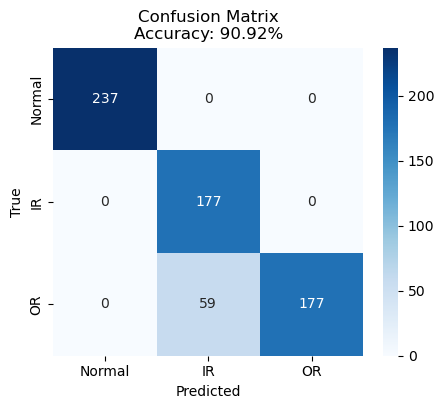

 - Model accuracy: 90.92%


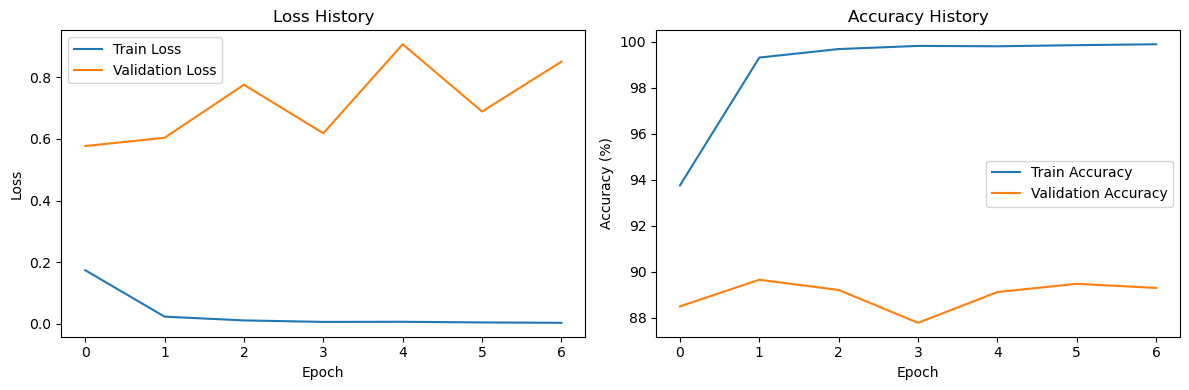

Early stopping at epoch 12


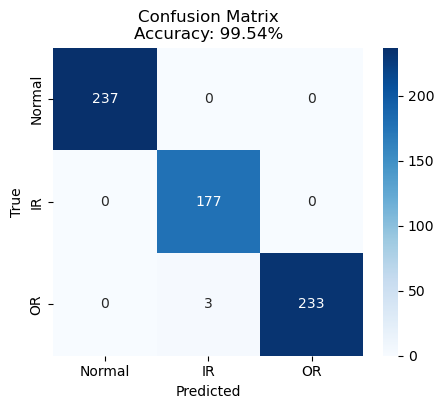

 - Model accuracy: 99.54%


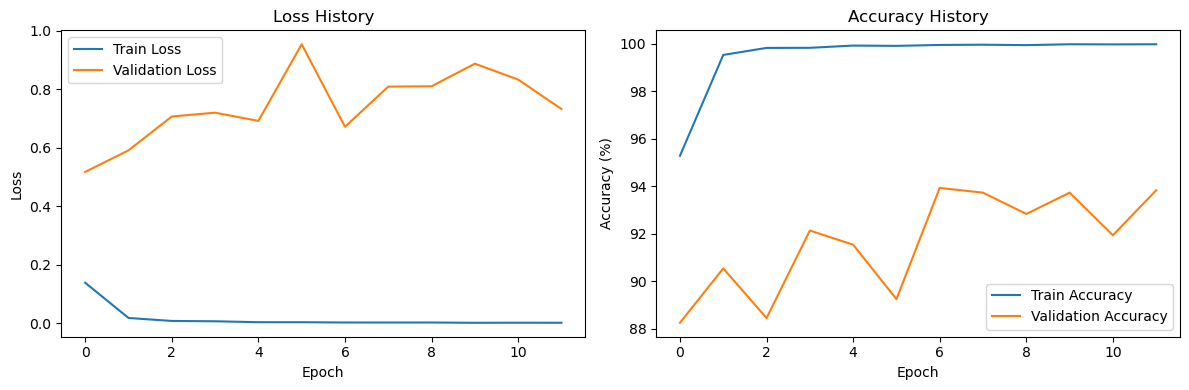

Early stopping at epoch 10


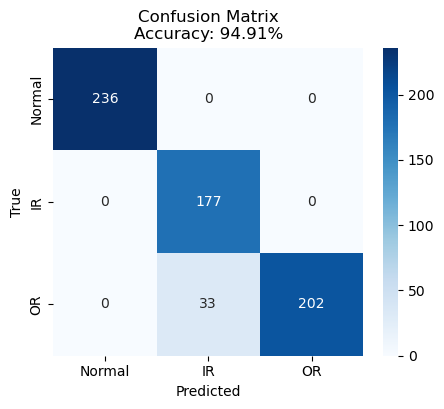

 - Model accuracy: 94.91%


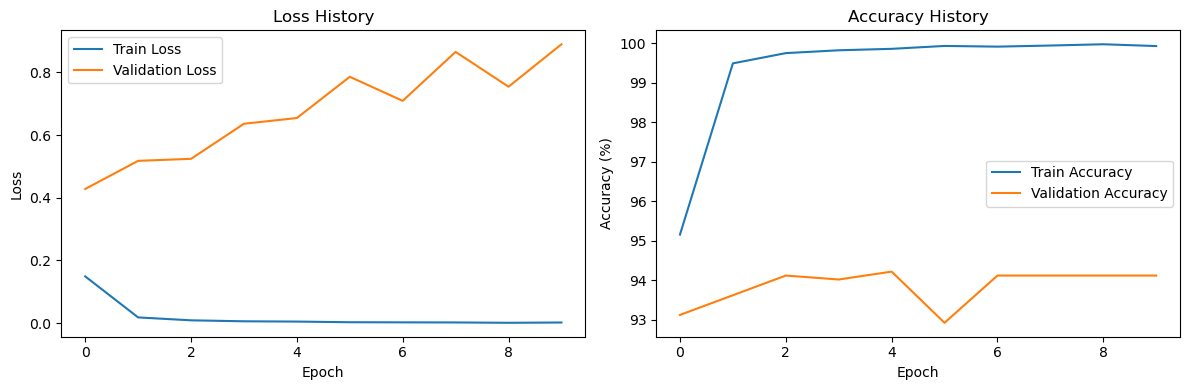

Early stopping at epoch 9


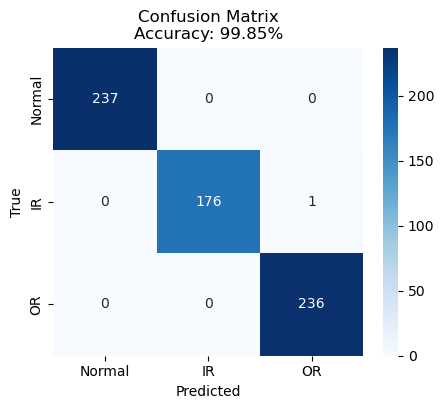

 - Model accuracy: 99.85%


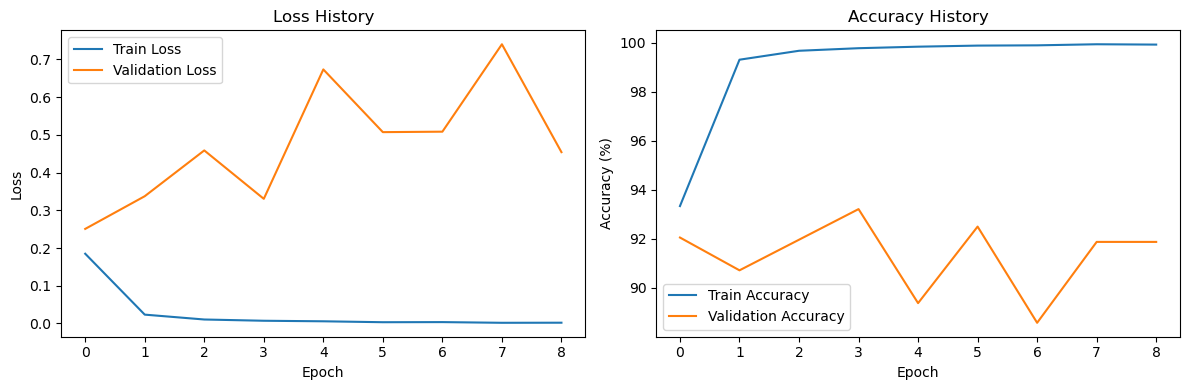

Early stopping at epoch 14


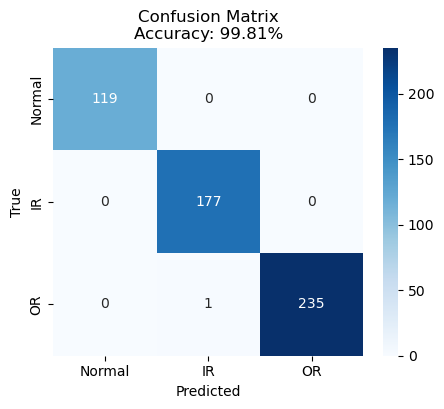

 - Model accuracy: 99.81%


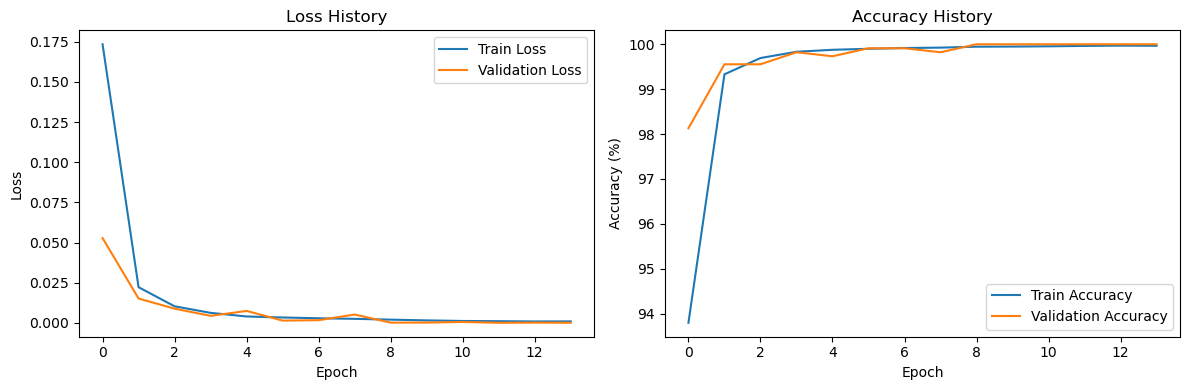

Early stopping at epoch 10


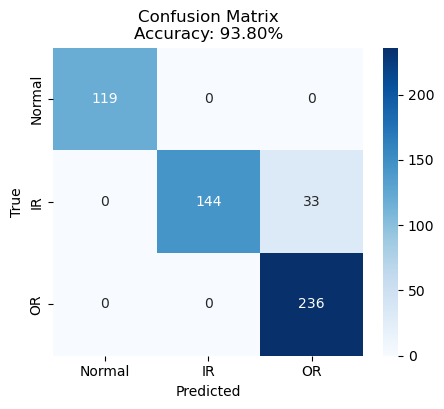

 - Model accuracy: 93.80%


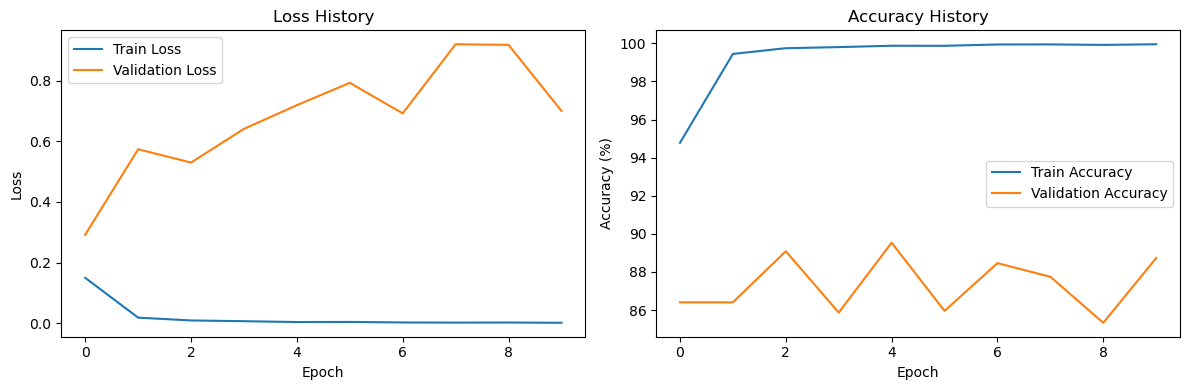

Mean accuracy: 0.8995193475529624
Std accuracy: 0.10054768881664215


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
from scipy.io import loadmat
import re
import random

# --- Import các module từ dự án của bạn ---
import cfg
from src import trainer, baseline_models, evaluate
from torch.utils.data import DataLoader, Dataset

# =====================================================================================
# PHẦN 1: LOGIC TẢI DỮ LIỆU THÔ (RAW DATA)
# =====================================================================================

def get_label_from_path(file_path: Path) -> int:
    """Hàm lấy nhãn từ đường dẫn file."""
    path_parts = file_path.parts
    if 'Normal' in path_parts: return 0
    elif 'IR' in path_parts: return 1
    elif 'OR' in path_parts: return 2
    return -1

def import_cwru_data_raw(file_keys: list, sample_length: int, base_path: str, overlapping_ratio: float = 0.0):
    """Hàm tải dữ liệu thô với tùy chọn overlapping."""
    all_samples, all_labels = [], []
    base_path_obj = Path(base_path)
    step = int(sample_length * (1 - overlapping_ratio))
    if step < 1: step = 1

    for key in file_keys:
        match = re.match(r'(\d+)(\w+)', key)
        if not match: continue
        file_num_str, data_key_suffix = match.groups()

        glob_pattern = f'{file_num_str}_*.mat'
        found_files = list(base_path_obj.rglob(glob_pattern))
        if not found_files: continue
        
        file_path = found_files[0]
        label = get_label_from_path(file_path)
        mat_data = loadmat(file_path)
        
        mat_key_zfill = f'X{file_num_str.zfill(3)}_{data_key_suffix}_time'
        mat_key_normal = f'X{file_num_str}_{data_key_suffix}_time'
        
        mat_key = mat_key_zfill if mat_key_zfill in mat_data else mat_key_normal
        if mat_key not in mat_data: continue

        time_series = mat_data[mat_key].flatten()

        for i in range(0, len(time_series) - sample_length + 1, step):
            all_samples.append(time_series[i : i + sample_length])
            all_labels.append(label)

    return np.array(all_samples), np.array(all_labels)

def data_import_raw(sample_length: int, overlapping_ratio: float, train_ratio=0.7, val_ratio=0.2):
    """Hàm chính để tải và chia dữ liệu thô."""
    normal_files = ['97DE', '97FE', '98DE', '98FE', '99DE', '99FE', '100DE', '100FE']
    ir_files = ['211DE', '279DE', '274FE', '272DE', '272FE', '272BA', '209DE', '209FE', '210DE', '278DE', '278FE', '280DE', '280BA', '271DE', '271FE', '271BA', '276FE', '276BA', '277FE', '277BA', '212DE', '281DE', '275FE', '273DE', '273FE', '273BA']
    or_files = ['132DE', '146DE', '146FE', '146BA', '159DE', '312DE', '312FE', '315DE', '133DE', '147DE', '147FE', '147BA', '160DE', '317DE', '317FE', '317BA', '130DE', '131DE', '144DE', '144BA', '145DE', '145FE', '145BA', '156DE', '156FE', '310DE', '310FE', '309DE', '311DE', '311FE', '313DE', '313FE']
    data = [normal_files, ir_files, or_files]

    train_files, val_files, test_files = [], [], []
    for fault in data:
        random.shuffle(fault)
        n_samples = len(fault)
        train_end = int(train_ratio * n_samples)
        val_end = train_end + round(val_ratio * n_samples)
        train_files.extend(fault[:train_end])
        val_files.extend(fault[train_end:val_end])
        test_files.extend(fault[val_end:])

    X_train, Y_train = import_cwru_data_raw(train_files, sample_length, cfg.BASE_PATH, overlapping_ratio)
    X_val, Y_val = import_cwru_data_raw(val_files, sample_length, cfg.BASE_PATH, 0.0)
    X_test, Y_test = import_cwru_data_raw(test_files, sample_length, cfg.BASE_PATH, 0.0)
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

class BearingDatasetRaw(Dataset):
    """
    Dataset cho dữ liệu thô.
    *** ĐÃ THÊM tùy chọn chuẩn hóa (normalization) ***
    """
    def __init__(self, X_data, Y_data, normalization=None):
        self.data = torch.from_numpy(X_data).float()
        self.labels = torch.from_numpy(Y_data).long()
        self.normalization = normalization

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        
        # Áp dụng chuẩn hóa nếu được chỉ định
        if self.normalization == 'z-score':
            # Thêm epsilon để tránh chia cho 0 nếu std là 0
            std = sample.std()
            if std > 1e-8:
                sample = (sample - sample.mean()) / std
        elif self.normalization == 'min-max':
            min_val = sample.min()
            max_val = sample.max()
            range_val = max_val - min_val
            if range_val > 1e-8:
                sample = (sample - min_val) / range_val

        # Thêm chiều kênh (channel dimension)
        return sample.unsqueeze(0), self.labels[idx]

# =====================================================================================
# PHẦN 2: QUY TRÌNH HUẤN LUYỆN WDCNN
# =====================================================================================

if __name__ == '__main__':
    # 1. Thiết lập các tham số
    WDCNN_INPUT_LENGTH = 2048
    TRAIN_OVERLAPPING_RATIO = 0.95
    # Tùy chọn chuẩn hóa: None, 'z-score', 'min-max'
    # Mặc định là None (tắt) theo yêu cầu của bạn.
    NORMALIZATION_METHOD = None 

    accuracy_list= []
    for i in range(30):
        trainer.set_seed(i)
        # 2. Tải và chuẩn bị dữ liệu
        X_train, Y_train, X_val, Y_val, X_test, Y_test = data_import_raw(
            sample_length=WDCNN_INPUT_LENGTH,
            overlapping_ratio=TRAIN_OVERLAPPING_RATIO
        )
        
        train_dataset = BearingDatasetRaw(X_train, Y_train)
        val_dataset = BearingDatasetRaw(X_val, Y_val)
        test_dataset = BearingDatasetRaw(X_test, Y_test)
            
        train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False)

        # 3. Khởi tạo mô hình, optimizer, scheduler, loss
        model = baseline_models.WDCNN(input_channels=1, num_classes=cfg.NUM_CLASSES)
        model.to(cfg.DEVICE)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=cfg.NUM_EPOCHS, eta_min=cfg.LEARNING_RATE * 1e-2
        )

        trained_model, history = trainer.train_model(
            model=model, 
            train_loader=train_loader, 
            val_loader=val_loader, 
            criterion=criterion, 
            optimizer=optimizer, 
            output_name='wdcnn_best.pth', # Tên file lưu model
            scheduler=scheduler, 
            num_epochs=50, 
            device=cfg.DEVICE
        )
        accuracy = evaluate.plot_confusion_matrix(trained_model, test_loader, 'cpu', cfg.CLASS_NAMES)
        accuracy_list.append(accuracy)
        evaluate.plot_history(history)

    print('='*20)
    print('Mean accuracy:', np.mean(accuracy_list))
    print('Std accuracy:', np.std(accuracy_list))


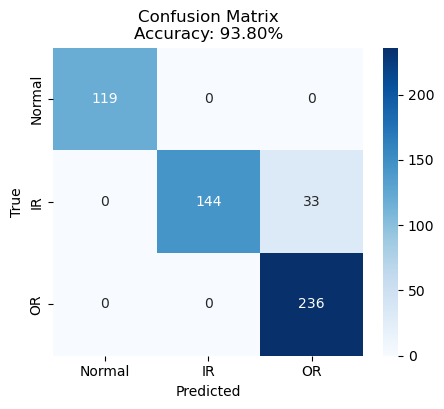

 - Model accuracy: 93.80%


In [2]:
from src import evaluate
test_dataset = BearingDatasetRaw(X_test, Y_test)

test_loader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True)

accuracy = evaluate.plot_confusion_matrix(trained_model, test_loader, 'cpu', cfg.CLASS_NAMES)